# TR Data Challenge 2023 - Data Analysis

This notebook reads and analyzes the TRDataChallenge2023.txt file containing legal documents.

In [39]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

## 1. Load the Data

In [2]:
def load_tr_data(file_path='/mnt/d/TR-Project/TRDataChallenge2023.txt'):
    """
    Load TR data from the text file.
    """
    documents = []
    
    print(f"Loading data from: {file_path}")
    file_size_mb = os.path.getsize(file_path) / (1024*1024)
    print(f"File size: {file_size_mb:.2f} MB")
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if line.strip():
                try:
                    doc = json.loads(line.strip())
                    documents.append(doc)
                    
                    if (i + 1) % 5000 == 0:
                        print(f"Loaded {i + 1} lines...")
                        
                except json.JSONDecodeError:
                    continue
    
    print(f"Total documents loaded: {len(documents)}")
    return documents

# Load the data
documents = load_tr_data()

Loading data from: /mnt/d/TR-Project/TRDataChallenge2023.txt
File size: 321.03 MB
Loaded 5000 lines...
Loaded 10000 lines...
Loaded 15000 lines...
Total documents loaded: 18000


## 2. Explore Raw Data Structure

#### explore data structure in terminal before reading it</br>
```bash
head -n 1 TRDataChallenge2023.txt | python3 -m json.tool
```

In [ ]:
# Examine the structure of the first document
if documents:
    print("Keys in first document:")
    print(list(documents[0].keys()))
    
    print("\nFirst document:")
    print(json.dumps(documents[0], indent=2)[:1000] + "...")  # Show first 1000 chars

Keys in first document:
['documentId', 'postures', 'sections']

First document:
{
  "documentId": "Ib4e590e0a55f11e8a5d58a2c8dcb28b5",
  "postures": [
    "On Appeal"
  ],
  "sections": [
    {
      "headtext": "",
      "paragraphs": [
        "Plaintiff Dwight Watson (\u201cHusband\u201d) appeals from the trial court\u2019s equitable distribution order entered 28 February 2017. On appeal, plaintiff contends that the trial court erred in its classification, valuation, and distribution of the parties\u2019 property and in granting defendant Gertha\u2009 Watson (\u201cWife\u201d) an unequal distribution of martial property. Because the trial court\u2019s findings of fact do not support its conclusions of law and because the distributional factors found by the trial court are based upon some of those erroneous findings and conclusions, we reverse the equitable distribution order and remand for entry of a new equitable distribution order."
      ]
    },
    {
      "headtext": "Backgrou

## 3. Convert to DataFrame

In [6]:
def create_dataframe(documents):
    """
    Convert documents to a pandas DataFrame.
    """
    data = []
    
    for doc in documents:
        # Basic document info
        row = {
            'document_id': doc.get('documentId', ''),
            'postures': ', '.join(doc.get('postures', [])),
            'num_postures': len(doc.get('postures', [])),
            'num_sections': len(doc.get('sections', [])),
        }
        
        # Extract text content
        all_text = []
        section_headers = []
        
        for section in doc.get('sections', []):
            header = section.get('headtext', '')
            if header:
                section_headers.append(header)
            
            paragraphs = section.get('paragraphs', [])
            all_text.extend(paragraphs)
        
        row['section_headers'] = ' | '.join(section_headers)
        row['full_text'] = ' '.join(all_text)
        row['text_length'] = len(row['full_text'])
        row['word_count'] = len(row['full_text'].split())
        row['num_paragraphs'] = len(all_text)
        row['num_headers'] = len(section_headers)
        
        data.append(row)
    
    return pd.DataFrame(data)

# Create DataFrame
df = create_dataframe(documents)
print(f"DataFrame shape: {df.shape}")
df.head(2)

DataFrame shape: (18000, 10)


,document_id,postures,num_postures,num_sections,section_headers,full_text,text_length,word_count,num_paragraphs,num_headers
0,Ib4e590e0a55f11e8a5d58a2c8dcb28b5,On Appeal,1,8,Background | Analysis | I. Classification issues | A. Cadillac El Dorado | B. Valuation of home ...,Plaintiff Dwight Watson (“Husband”) appeals from the trial court’s equitable distribution order ...,25583,4224,44,7
1,Ib06ab4d056a011e98c7a8e995225dbf9,"Appellate Review, Sentencing or Penalty Phase Motion or Objection",2,10,A. Offense Conduct | B. Prior Convictions | C. Guilty Plea | D. Sentencing | II. DISCUSSION | A....,"After pleading guilty, William Jerome Howard, Jr., appeals his 168-month sentence for possession...",18846,3004,29,9


In [19]:
text="""
Examining the postures values in the dataframe reveals this is a classic multi-label classification problem. Each document can be assigned multiple posture labels simultaneously.
"""
from rich.console  import Console
console=Console()
console.print(text, style="bold white", justify="left")

                                                                                                                   
Examining the postures values in the dataframe reveals this is a classic multi-label classification problem. Each  
document can be assigned multiple posture labels simultaneously.                                                   
                                                                                                                   

In [21]:
from IPython.display import HTML, display

text = (
    "Examining the posture values in the dataframe reveals this is a classic "
    "multi-label classification problem. Each document can be assigned multiple "
    "posture labels simultaneously."
)

display(HTML(f'<span style="font-size: 150%;">{text}</span>'))

## 4. Data Analysis and Visualization

In [7]:
# Basic statistics
print("Dataset Overview:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   document_id      18000 non-null  object
 1   postures         18000 non-null  object
 2   num_postures     18000 non-null  int64 
 3   num_sections     18000 non-null  int64 
 4   section_headers  18000 non-null  object
 5   full_text        18000 non-null  object
 6   text_length      18000 non-null  int64 
 7   word_count       18000 non-null  int64 
 8   num_paragraphs   18000 non-null  int64 
 9   num_headers      18000 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 1.4+ MB
None

Descriptive Statistics:
       num_postures  num_sections    text_length     word_count  \
count  18000.000000  18000.000000   18000.000000   18000.000000   
mean       1.536611      5.086889   17986.551944    2891.668778   
std        0.752936      5.730469   19491.445944    

### text length distribution

<span style="color: red; font-weight: bold; font-size: 18px;"> **Text Length Analysis for Model Selection and Optimization**</br>

Analyzing text length distribution is a critical preprocessing step that directly influences model architecture selection and performance optimization. When deploying Large Language Models (LLMs) for this multi-label classification task, context length becomes a pivotal consideration due to several key factors:

**Context Length Constraints:** </br>Each LLM architecture has a predefined maximum context length (e.g., 512 tokens for BERT, 4096 for Longformer, 8192 for MordernBERT, 10000+ for many decoder models(Llama, Mistral, Qwen family etc)). Understanding our data's text length distribution enables informed model selection that balances computational efficiency with information preservation.

**Resource Optimization:**</br> Oversized context windows lead to unnecessary computational overhead and increased memory consumption without performance gains. Conversely, insufficient context length results in critical information truncation, potentially degrading model accuracy.

**Strategic Implications:** </br>By examining the statistical distribution of text lengths across our dataset, we can:

Select appropriate model architectures with optimal context lengths
Implement efficient text preprocessing strategies (chunking, summarization, or truncation)
Estimate computational requirements and training costs
Ensure minimal information loss during model input preparation
This analysis forms the foundation for making data-driven decisions regarding model selection and hyperparameter configuration. </span>

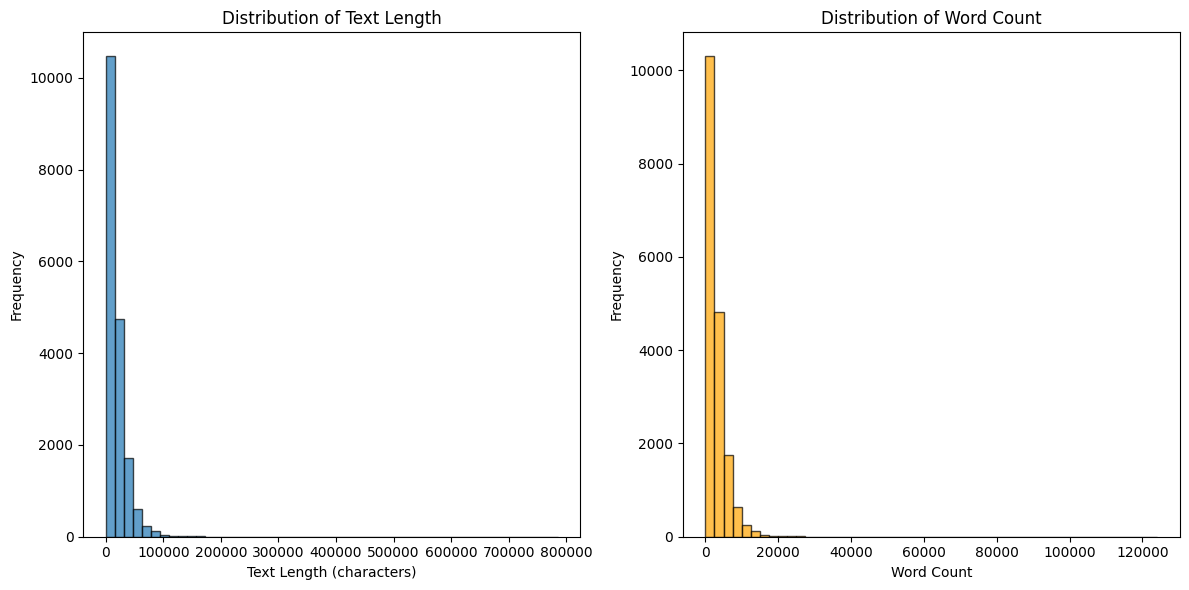

In [24]:
# Text length distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['word_count'], bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<span style="font-weight: bold; font-size: 18px;"> **Accurate Text Length Measurement Using Subword Tokenization**</br>

The initial text length analysis employed a basic word-counting approach using whitespace as delimiters. However, this naive methodology fails to accurately represent how Large Language Models process and interpret textual input, leading to potential misestimation of context requirements.

**Tokenization Discrepancy:**</br> LLMs do not process text at the word level as humans do. Instead, they utilize sophisticated subword tokenization algorithms including:

<div style="margin-left: 20px;">1. Byte Pair Encoding (BPE): Used by GPT models</div>
<div style="margin-left: 20px;">2. WordPiece: Employed by BERT variants</div>
<div style="margin-left: 20px;">3. SentencePiece: Utilized by T5 and many multilingual models</div>

**Technical Implementation:**</br> To obtain precise context length measurements that align with actual LLM processing, we implement tokenization using ModernBERT, which employs BPE (Byte Pair Encoding) for subword segmentation. This approach provides several advantages:

<div style="margin-left: 20px;">1. Accurate Token Counting: Measures text length in the same units that the model processes</div>
<div style="margin-left: 20px;">2. Context Window Optimization: Enables precise estimation of how much text fits within model constraints</div>
<div style="margin-left: 20px;">3. Model-Agnostic Approach: The methodology can be adapted for different tokenizers (e.g., GPT-2/3/4 or many other LLMs' tokenizer) based on target model selection</div>


</span>

### text length distribution using subword tokenization

In [25]:
from transformers import AutoTokenizer
model_path = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_path)


/mnt/d/TR-Project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [38]:
from datasets import Dataset
# text_df=df["full_text"].to_frame("text")
text_df=df.loc[:,["full_text","postures"]]
hf=Dataset.from_pandas(text_df)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
hf=hf.map(lambda x: tokenizer(x["full_text"]),batched=True)
hf=hf.map(compute_lenth)
df0=hf.to_pandas()

Map: 100%|██████████| 18000/18000 [00:24<00:00, 728.65 examples/s] 


In [44]:
def statistics_compute(data,p=1):
    X=[]
    X.append(np.percentile(data['text_length'],p))
    result={}
    result['percentile']=X
    result["min"]=[np.min(data['text_length'])]
    result["max"]=[np.max(data['text_length'])]
    result["mean"]=[np.mean(data['text_length'])]
    return result

def statistics_table(data):
    dict_data={}
    dict_data["data_type"]=["full_text"]
    dict_data["# of obs"]=[len(data['text_length'])]
    dict_data["Min"]=statistics_compute(data)["min"]
    dict_data["5%"]=statistics_compute(data, p=5)['percentile']
    dict_data["10%"]=statistics_compute(data, p=10)['percentile']
    dict_data["25%"]=statistics_compute(data, p=25)['percentile']
    dict_data["Median"]=statistics_compute(data, p=50)['percentile']
    dict_data["Average"]=statistics_compute(data)["mean"]
    dict_data["75%"]=statistics_compute(data, p=75)['percentile']
    dict_data["90%"]=statistics_compute(data, p=90)['percentile']
    dict_data["95%"]=statistics_compute(data, p=95)['percentile']
    dict_data["Max"]=statistics_compute(data)["max"]
    token_count_df=pd.DataFrame(dict_data)
    
    token_count_df["# of obs"] = token_count_df["# of obs"].apply(lambda x: f"{int(x):,}")
    token_count_df["Min"] = token_count_df["Min"].apply(lambda x: f"{int(x):,}")
    token_count_df["5%"] = token_count_df["5%"].apply(lambda x: f"{int(x):,}")
    token_count_df["10%"] = token_count_df["10%"].apply(lambda x: f"{int(x):,}")
    token_count_df["25%"] = token_count_df["25%"].apply(lambda x: f"{int(x):,}")
    token_count_df["Median"] = token_count_df["Median"].apply(lambda x: f"{int(x):,}")
    token_count_df["Average"] = token_count_df["Average"].apply(lambda x: f"{int(x):,}")
    token_count_df["75%"] = token_count_df["75%"].apply(lambda x: f"{int(x):,}")
    token_count_df["90%"] = token_count_df["90%"].apply(lambda x: f"{int(x):,}")
    token_count_df["95%"] = token_count_df["95%"].apply(lambda x: f"{int(x):,}")
    token_count_df["Max"] = token_count_df["Max"].apply(lambda x: f"{int(x):,}")
    
    return token_count_df

In [45]:
statistics_table(df0)

,data_type,# of obs,Min,5%,10%,25%,Median,Average,75%,90%,95%,Max
0,full_text,"18,000",2,573,766,"1,366","2,883","4,072","5,334","8,608","11,371","204,974"


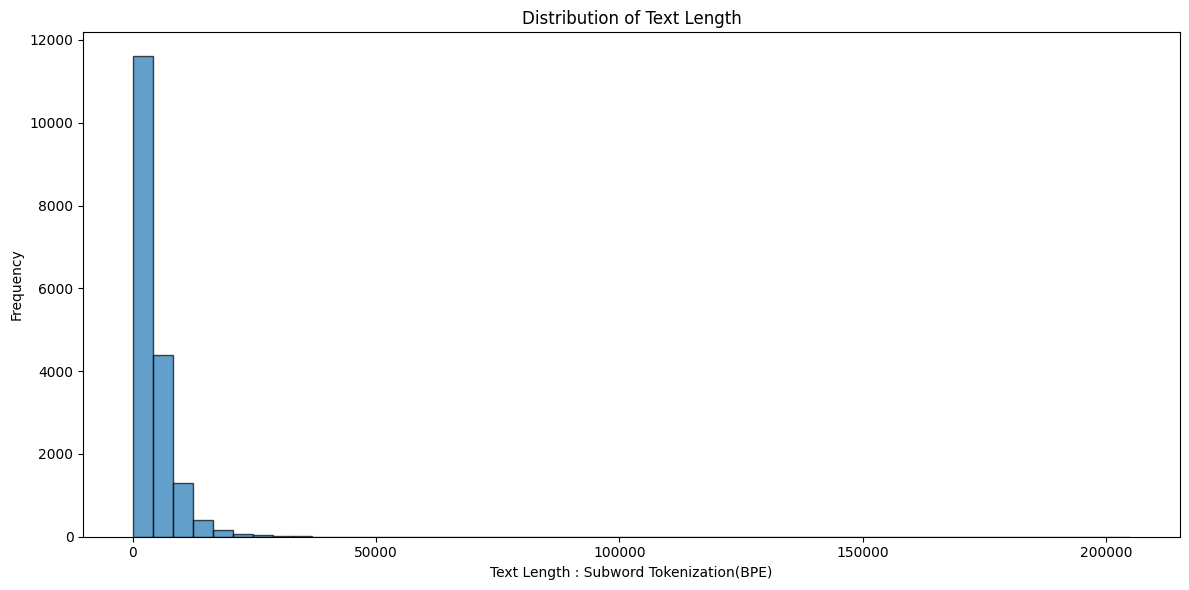

In [47]:
# Text length distribution
plt.figure(figsize=(12, 6))

plt.hist(df0['text_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length : Subword Tokenization(BPE)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<span style="font-weight: bold; font-size: 18px;">**Subword Tokenization Analysis Results and Model Selection**</br>

The subword tokenization analysis reveals that the average text length across the corpus is 4,072 tokens. When considering ModernBERT as our target language model, which supports a maximum context length of 8,192 tokens, this configuration provides excellent coverage for our dataset.

Key Findings:

<div style="margin-left: 20px;"> •  Average token length: 4,072 tokens per document</div>
<div style="margin-left: 20px;"> •  Model capacity: ModernBERT's 8,192-token context window</div>
<div style="margin-left: 20px;"> •  Coverage efficiency: Approximately 90% of documents (up to 8,608 tokens) can be processed without truncation</div>


</span>